In [2]:
# System libraries
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

# Pytorch/TIMM libraries
import timm
from timm.models.helpers import model_parameters
import torch.nn as nn
import torch
from torchprofile import profile_macs
from torch.profiler import profile, record_function, ProfilerActivity

# Helper libraries
import numpy as np
import json
from PIL import Image

# Data visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter

# Environment variables
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

# Commands
# tensorboard --logdir=./my_work/v2/logs

In [3]:
# models = [model for model in timm.list_models('vit*')]
# print([x for x in models if 'vitamin' not in str(x)])
model_name = "vit_base_patch16_224"

#TODO Learn how to use SummaryWriter

In [26]:
class Analyzer:
    def __init__(self, model_name, device="cpu", pretrained=True, pretrained_cfg=None, pretrained_cfg_overlay=None,
                checkpoint_path='', scriptable=None, exportable=None, no_jit=True):
        self.model_name = model_name
        self.device = torch.device(device if torch.cuda.is_available() and device == "cuda" else "cpu")
        print(f"Using device: {self.device}")
        self.model = timm.create_model(
            model_name, pretrained=pretrained, pretrained_cfg=pretrained_cfg, pretrained_cfg_overlay=pretrained_cfg_overlay,
            checkpoint_path=checkpoint_path, scriptable=scriptable, exportable=exportable, no_jit=no_jit
        ).to(self.device)
        self.profiler = None  
        
        # print(self.model.default_cfg)
        # params = sum(p.numel() for p in self.model.parameters())
        # print(f"Number of parameters: {params / 1e6:.2f}M")
    
    def inference_one(self, input_tensor: torch.Tensor) -> None:
        """Run inference on a single input tensor."""
        input_tensor = input_tensor.to(self.device)
        self.model.eval()  
        with torch.no_grad():
            output = self.model(input_tensor)
            print(f"Model device: {next(self.model.parameters()).device}")
            print(f"Input tensor device: {input_tensor.device}")

        return output
    
    def start_profiler(self, create_logfile=False) -> None:
        """Initialize and start the profiler."""
        if create_logfile:
            trace_handler = torch.profiler.tensorboard_trace_handler('./logs')
        else:
            trace_handler = None
            
        self.profiler = profile(
            activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
            on_trace_ready=trace_handler,
            record_shapes=True,
            with_stack=True,
            with_flops=True,
            profile_memory=True,
            with_modules=True
        )
        self.profiler.__enter__()  # Start the profiler context manually

    def stop_profiler(self) -> None:
        """Stop the profiler and process the collected data."""
        if self.profiler:
            self.profiler.__exit__(None, None, None) 
            
    def is_cuda_unilized(self, logs=False) -> None:
        for name, param in self.model.named_parameters():
            if param.device.type != "cuda":
                if logs:	
                    print(f"Parameter {name} is not on GPU")
                else:
                    print("Some or all model parameters are not on GPU")
                    return
                # return False
        print("All model parameters are on the GPU")
        # return True

    def list_events(self, show_key_averages=False, list_all=False) -> None:
        """
        List all recorded events from the profiler.	
        name	         - The name of the operation (e.g., aten::add, aten::matmul, aten::conv2d).
		cpu_time_total	 - Total time spent on the CPU for this operation, in microseconds.
		cuda_time_total	 - Total time spent on the GPU for this operation, in microseconds.
		input_shapes	 - Shapes of the tensors used as inputs to this operation.
		output_shapes	 - Shapes of the tensors produced by this operation (if applicable).
		device_type	     - Whether the operation was executed on CPU or CUDA.
		device	         - The device ID on which the operation was executed.
		self_cpu_time	 - Time spent on the CPU for this operation alone (excluding time for child operations).
		self_cuda_time   - Time spent on the GPU for this operation alone (excluding time for child operations).
		"""
        if self.profiler is None:
            print("Profiler has not been initialized or profiling session has ended.")
        else:
            if show_key_averages:	
                print(self.profiler.key_averages().table())
            if list_all:
                for event in self.profiler.events():
                    print(f"Name: {event.name}, CPU Time: {event.cpu_time_total}, CUDA Time: {event.cuda_time_total}")
    
    def event_handler(self, create_csv_file=False, log_to_tensorboard=False, plot_events=False, log_dir='logs') -> None:
        #TODO IGNORES [memory] EVENTS FOR NOW, LOOK INTO IT
        if self.profiler is None:
            print("Profiler has not been initialized or profiling session has ended.")
        else:         
            key_averages = self.profiler.key_averages()
            
            def helper(key_averages=key_averages):
                # Helper code to print all events and their attributes
                for i, event in enumerate(key_averages):
                    print(f"Event {i + 1} name: {event.key}")
                    attributes = [attr for attr in dir(event) if not attr.startswith("_") and not callable(getattr(event, attr))]
                    for attr in attributes:
                        print(f"  {attr}: {getattr(event, attr)}")
                    print("-" * 50)  # Separator between events
            # helper()
                
            profiler_data = []
            
            if log_to_tensorboard:
                writer = SummaryWriter(log_dir=log_dir) 
                
            for event in key_averages:
                if not event.key == "[memory]":
                    cpu_children_time = event.cpu_time_total - event.self_cpu_time_total
                    cuda_children_time = event.device_time_total - event.self_device_time_total
                    
                    event_data = {
                        "Name": event.key,
                        "Count": event.count,
                        # Timing attributes
                        "CPU time op only": event.self_cpu_time_total,
                        "CPU time total (+children)": event.cpu_time_total,
                        "CPU children time": cpu_children_time,
						"CUDA time op only": event.self_device_time_total,
						"CUDA time total (+children)": event.device_time_total,
						"CUDA children time": cuda_children_time,	
						# Memory attributes
						"CPU memory usage (+children)": event.cpu_memory_usage,
						"CPU memory usage op only": event.self_cpu_memory_usage,
						"CUDA memory usage (+children)": event.device_memory_usage,
						"CUDA memory usage op only": event.self_device_memory_usage,
						# Performance
						"Flops": event.flops,	
						"Is Async": event.is_async,
						"Input Shapes": event.input_shapes,
						"Stack": event.stack
					}
                    
                    profiler_data.append(event_data)
                    
                    # TODO Make this alot better, looks like shit
                    # Log metrics to TensorBoard
                    if log_to_tensorboard:
                        writer.add_scalar("Performance/CPU_time_op_only", event.self_cpu_time_total, global_step=event.count)
                        writer.add_scalar("Performance/CPU_time_total", event.cpu_time_total, global_step=event.count)
                        writer.add_scalar("Performance/CPU_children_time", cpu_children_time, global_step=event.count)
                        writer.add_scalar("Performance/CUDA_time_op_only", event.self_device_time_total, global_step=event.count)
                        writer.add_scalar("Performance/CUDA_time_total", event.device_time_total, global_step=event.count)
                        writer.add_scalar("Performance/CUDA_children_time", cuda_children_time, global_step=event.count)
                        writer.add_scalar("Performance/FLOPS", event.flops, global_step=event.count)
                        writer.add_scalar("Memory/CPU_memory_usage_children", event.cpu_memory_usage, global_step=event.count)
                        writer.add_scalar("Memory/CUDA_memory_usage_children", event.device_memory_usage, global_step=event.count)
                        
            if create_csv_file:
                df.to_csv(f"./csvs/{self.model_name}_profiler_data.csv", index=False)
                
            if log_to_tensorboard:
                writer.close()
                
            if plot_events:
                df = pd.DataFrame(profiler_data)
                numeric_columns = [
					"CPU time op only", "CPU time total (+children)", "CPU children time",
					"CUDA time op only", "CUDA time total (+children)", "CUDA children time",
					"CPU memory usage (+children)", "CPU memory usage op only",
					"CUDA memory usage (+children)", "CUDA memory usage op only", "Flops"
				]
                df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')
                df = df.dropna()

				# CPU vs CUDA Time (Operation Only)
                plt.figure(figsize=(14, 6))
                df_melted = df.melt(
                    id_vars=["Name"], 
                    value_vars=["CPU time op only", "CUDA time op only"],
                    var_name="Type", 
                    value_name="Time (us)"
                )	
                sns.barplot(data=df_melted, x="Name", y="Time (us)", hue="Type")
                plt.xticks(rotation=90)
                plt.title("CPU vs CUDA Time (Operation Only)")
                plt.show()
                
                # CUDA Memory Usage by Operation
                plt.figure(figsize=(10, 8))
                sns.barplot(data=df, y="Name", x="CUDA memory usage (+children)", orient="h")
                plt.title("CUDA Memory Usage by Operation")
                plt.xlabel("Memory Usage (bytes)")
                plt.ylabel("Operation Name")
                plt.show()
    
				# CUDA Time vs CPU Time
                plt.figure(figsize=(8, 6))
                sns.scatterplot(data=df, x="CPU time total (+children)", y="CUDA time total (+children)")
                plt.title("CUDA Time vs CPU Time")
                plt.xlabel("CPU Time Total (us)")
                plt.ylabel("CUDA Time Total (us)")
                plt.show()
    
				# Correlation Heatmap of Metrics
                plt.figure(figsize=(10, 8))
                correlation = df[numeric_columns].corr()
                sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")
                plt.title("Correlation Heatmap of Metrics")
                plt.show()
    
				# Distribution of CPU and CUDA Times
                plt.figure(figsize=(14, 6))
                df_melted = df.melt(
                    id_vars=["Name"], 
                    value_vars=["CPU time total (+children)", "CUDA time total (+children)"],
                    var_name="Type", 
                    value_name="Time (us)"
                )
                sns.boxplot(data=df_melted, x="Type", y="Time (us)")
                plt.title("Distribution of CPU and CUDA Times")
                plt.show()    
    

In [5]:
def del_logs():
    for file in os.listdir('./logs'):
        os.remove(os.path.join('./logs', file))

del_logs()

In [6]:
def del_csvs():
    for file in os.listdir('./csvs'):
        os.remove(os.path.join('./csvs', file))

del_csvs()

Using device: cuda
Model device: cuda:0
Input tensor device: cuda:0
All model parameters are on the GPU


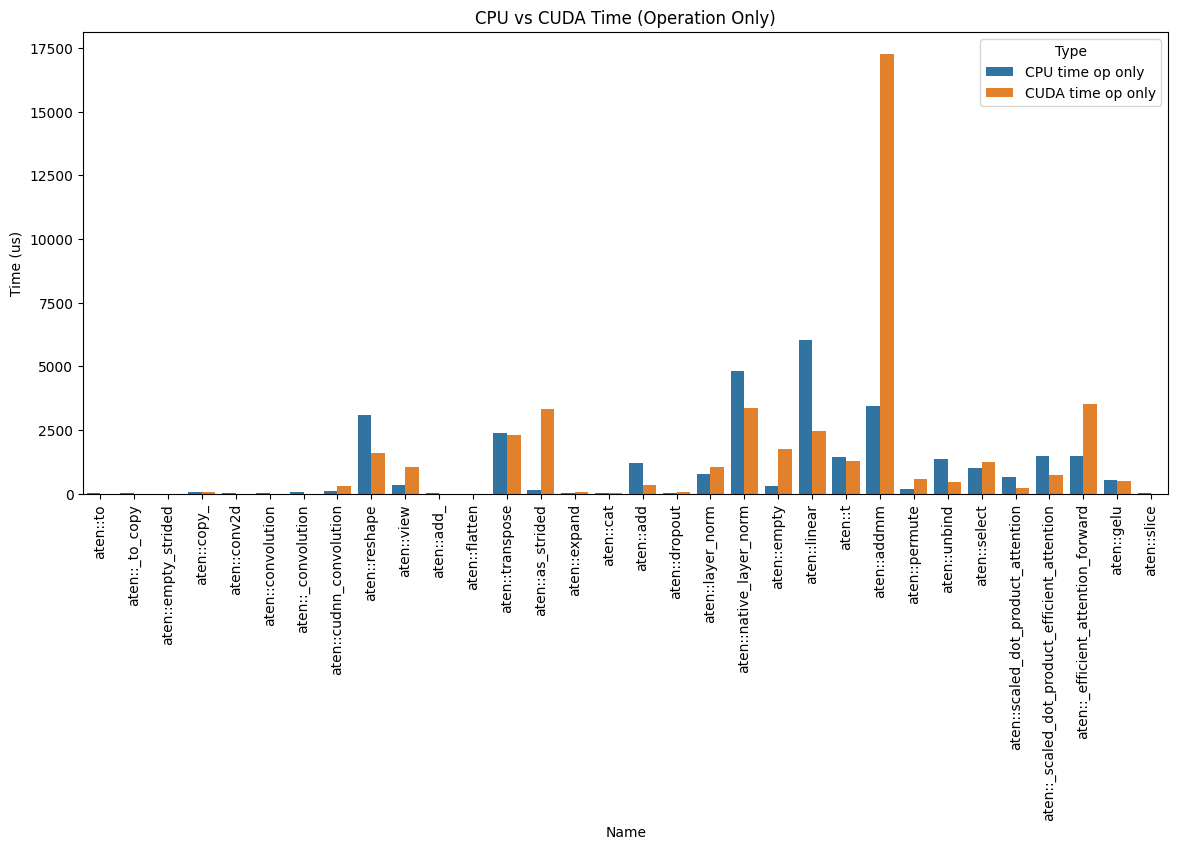

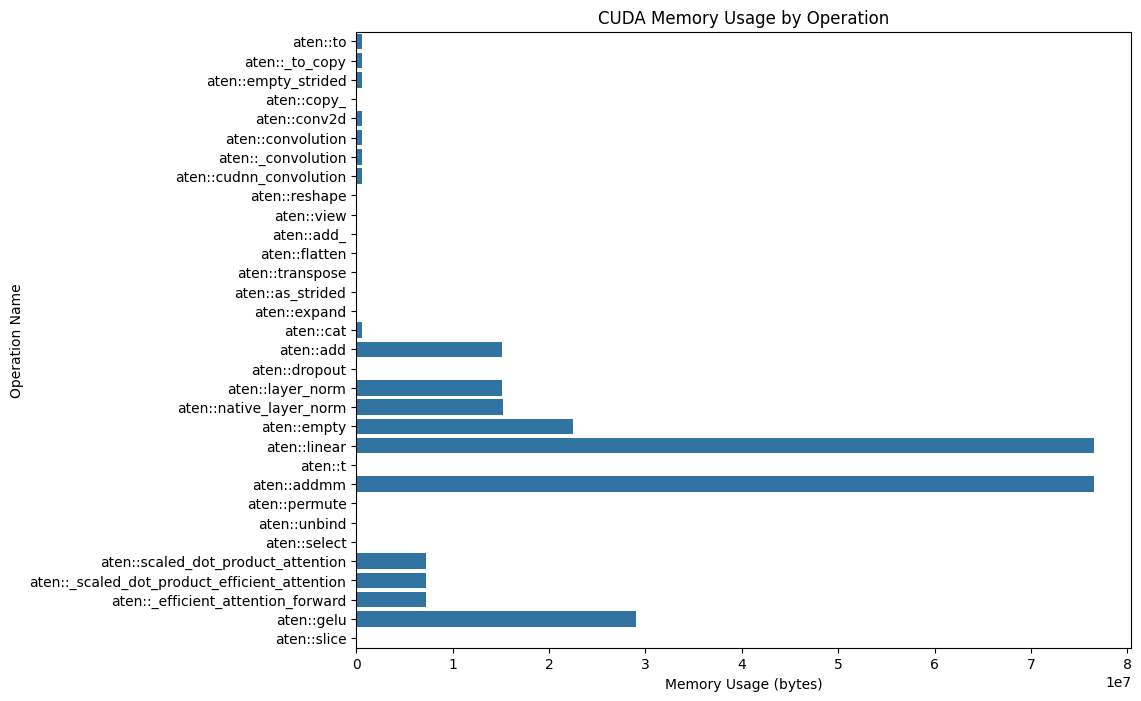

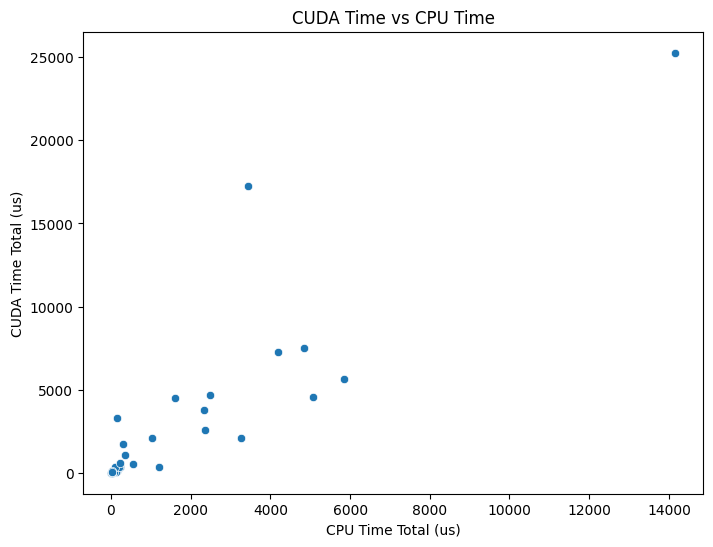

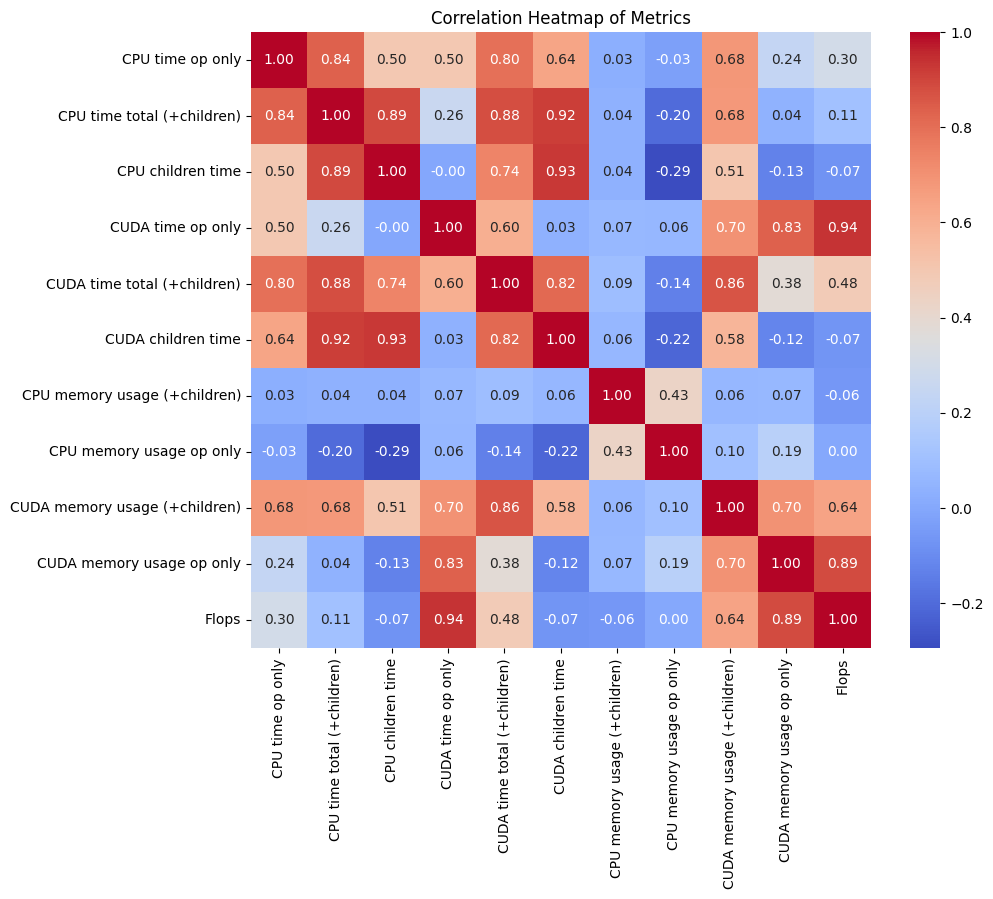

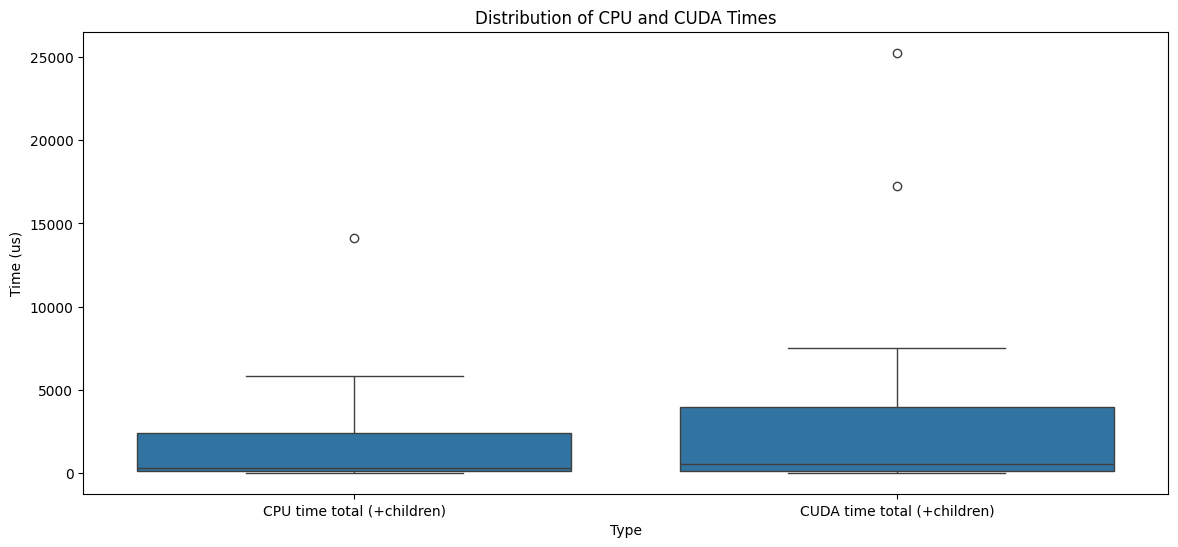

In [27]:
analyzer = Analyzer(model_name, device="cuda")
input_tensor = torch.randn(1, 3, 224, 224)
analyzer.start_profiler(create_logfile=False)
analyzer.inference_one(input_tensor)
analyzer.stop_profiler()
analyzer.is_cuda_unilized(logs=False)
analyzer.list_events(show_key_averages=False, list_all=False)
analyzer.event_handler(create_csv_file=False, log_to_tensorboard=False, plot_events=True, log_dir='logs')

